In [1]:
# Deep Learning Lib
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint_adjoint as odeint

# Data Manipulation Lib
import numpy as np
import random

# Data Loading Lib
import json

# Visualization library
from pprint import pprint
import matplotlib.pyplot as plt

# Helper Modules
from lib.utils import *
from lib.odefunc import *

# Misc
import os
import warnings
from joblib import Parallel, delayed
warnings.filterwarnings('ignore')

In [2]:
# Define some constants
ROOT_PATH = "./data"
CHECKPOINT_PATH = './checkpoint/state_dict_'
FILE_NAME = 'strogatz_extended.json'
SEED = 42
EPOCHS = 2000
N_LAYERS = 4
N_UNITS = 50
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Read dataset
with open(os.path.join(ROOT_PATH, FILE_NAME)) as strogatz:
    data = np.array(json.load(strogatz))

In [4]:
# Define model (for one 2D equation)
ode = data[26]
ode_func = ODEfunc(ode['dim'], N_LAYERS, N_UNITS, DEVICE)

# Set best loss
best_loss = float('inf')

In [5]:
def get_batch_single(ode_dim, data, t, batch_len=50, batch_size=1, device = torch.device("cpu")):
	s = torch.from_numpy(np.random.choice(np.arange(len(t) - batch_len, dtype=np.int64), batch_size, replace=False))
	data = data.reshape(-1, 2)

	batch_y0 = data[s]  # (M, D)
	batch_t = t[:batch_len]  # (T)
	batch_y = torch.stack([data[s + i] for i in range(batch_len)], dim=0)  # (T, M, D)

	return batch_y0.to(device), batch_t.to(device), batch_y.to(device)


In [6]:
# Define optimizer and start training
optimizer = optim.Adamax(ode_func.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9987)

# Set train_dict
train_dict = ode['solutions'][0]

# Training loop
for itr in range(EPOCHS):
    # Separate required variables
    X_train = torch.tensor(train_dict[0]['y'])
    t = torch.tensor(train_dict[0]['t'])

    # Set required variables
    optimizer.zero_grad()
    
    # Get batches of data
    batch_y0, batch_t, batch_y = get_batch_single(2, X_train, t, batch_len=20, device = DEVICE)
    # print(batch_y0.shape)
    # print(batch_t.shape)
    # print(batch_y.shape)

    # Train the Neural ODEs
    pred_y = odeint(ode_func, batch_y0, batch_t).to(DEVICE).transpose(0,1)
    loss = torch.mean((pred_y - batch_y)**2)

    # break
    
    # Print the loss
    if (itr + 1) % 20 == 0 or itr == 0:
        print(f'Epoch {itr + 1} / {EPOCHS} Loss {loss.item()}')
    
    # print(f'Epoch {itr + 1} / {EPOCHS} Loss {loss.item()}')

    
    # Save checkpoint if lesser error
    if best_loss > loss:
        best_loss = loss
        ckpt_path = CHECKPOINT_PATH + str(26) + '.ckpt'
        # print(ckpt_path)
        torch.save({'state_dict': ode_func.state_dict(),}, ckpt_path)

    # Backprop and step up
    loss.backward()
    optimizer.step()
    scheduler.step()

Epoch 1 / 2000 Loss 0.08279731124639511
Epoch 20 / 2000 Loss 20.490137100219727
Epoch 40 / 2000 Loss 34.320621490478516
Epoch 60 / 2000 Loss 0.06704133003950119
Epoch 80 / 2000 Loss 0.3710368275642395
Epoch 100 / 2000 Loss 0.007671620696783066
Epoch 120 / 2000 Loss 0.025694571435451508
Epoch 140 / 2000 Loss 0.6605742573738098
Epoch 160 / 2000 Loss 42.41133117675781
Epoch 180 / 2000 Loss 14.903467178344727
Epoch 200 / 2000 Loss 11.93359088897705
Epoch 220 / 2000 Loss 8.982712745666504
Epoch 240 / 2000 Loss 1.1159610748291016
Epoch 260 / 2000 Loss 23.457103729248047
Epoch 280 / 2000 Loss 0.37610357999801636
Epoch 300 / 2000 Loss 0.38180679082870483
Epoch 320 / 2000 Loss 0.24925550818443298
Epoch 340 / 2000 Loss 0.503677487373352
Epoch 360 / 2000 Loss 1.9509130716323853
Epoch 380 / 2000 Loss 0.24408257007598877
Epoch 400 / 2000 Loss 0.2121192216873169
Epoch 420 / 2000 Loss 14.990264892578125
Epoch 440 / 2000 Loss 0.3952867090702057
Epoch 460 / 2000 Loss 25.21416473388672
Epoch 480 / 2000 

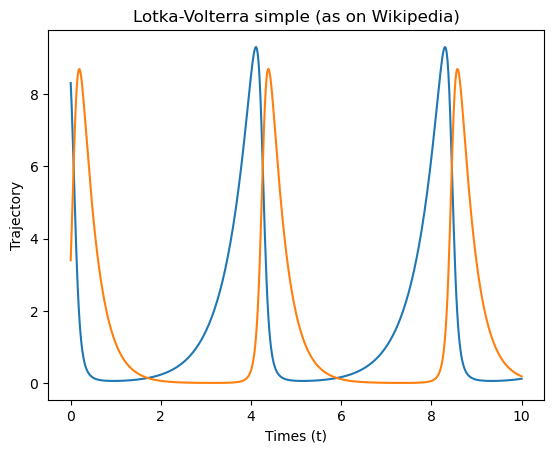

In [11]:
t = ode['solutions'][0][0]['t']

trajectory_1 = ode['solutions'][0][0]['y'][0]
trajectory_2 = ode['solutions'][0][0]['y'][1]

plt.xlabel("Times (t)")
plt.ylabel('Trajectory')
plt.plot(t, trajectory_1)
plt.plot(t, trajectory_2)
plt.title(ode.get('eq_description'))
plt.show()

In [12]:
batch_y0, batch_t, batch_y = get_batch_single(2, torch.tensor(ode['solutions'][0][0]['y']), torch.tensor(ode['solutions'][0][0]['t']), batch_len=400, device = DEVICE)
batch_y0 = batch_y0.reshape(-1, 2)
pred_y = odeint(ode_func, batch_y0, batch_t)

In [13]:
pred_y = pred_y.reshape(1, -1, 2)
pred_y.shape

torch.Size([1, 400, 2])

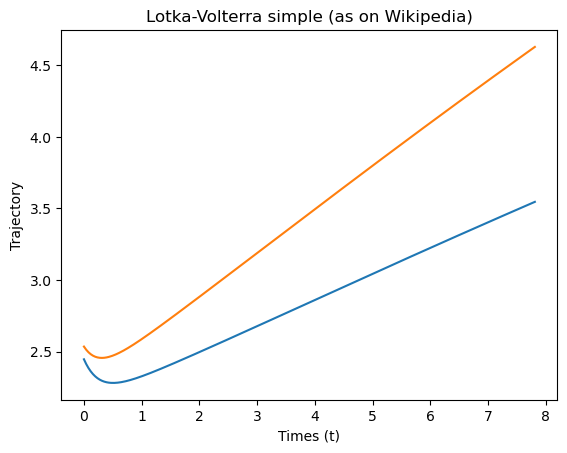

In [14]:
pred_trajectory_1 = pred_y[0][:,0]
pred_trajectory_2 = pred_y[0][:,1]

plt.xlabel("Times (t)")
plt.ylabel('Trajectory')
plt.plot(batch_t.detach().numpy(), pred_trajectory_1.detach().numpy())
plt.plot(batch_t.detach().numpy(), pred_trajectory_2.detach().numpy())
plt.title(ode.get('eq_description'))
plt.show()